## Clean Semi-supervised `MobileNetV3` model

In [1]:
import os
import torch
import argparse
import copy
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from mobilenetv3 import MobileNetV3
from tqdm.auto import tqdm
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, Subset
from new_datasets import TrafficSignDataset
from sklearn.model_selection import train_test_split
# from utils import save_model, save_plots
# from utils import save_plots
# from ResultWriter import ResultWriter 
# from statistics import accuracy, AverageMeter, ProgressMeter

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [2]:
# For mobilenetv3
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                        (0.2724, 0.2608, 0.2669))
])
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                        (0.2724, 0.2608, 0.2669))
])

### Split train dataset into `labeled` and `unlabeled` dataset

In [3]:
# Load the training and validation datasets.
train_dir = '../inputs/cifar10/train'
test_dir = '../inputs/cifar10/test'

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform) 

test_size =  len(test_dataset)
classes = train_dataset.classes
targets = train_dataset.targets # classes 

# split train data into lbl, unlbl dataset with the ratio of 1:9
label_idx, unlabelled_idx = train_test_split(np.arange(len(targets)), 
                                        test_size = 0.9, 
                                        shuffle = True, 
                                        stratify = targets)

#create a dict of labelled data (idx: label)
lb, gt_labels = {}, []
for img_idx in label_idx:
    lb[img_idx] = train_dataset.targets[img_idx]

for idx in unlabelled_idx:
    gt_labels.append(train_dataset.targets[idx])

label_dataset = Subset(train_dataset, label_idx)
unlabelled_dataset = Subset(train_dataset, unlabelled_idx)

label_size = len(label_dataset)
unlabelled_size = len(unlabelled_dataset)

labelled_loader = DataLoader(
    label_dataset, batch_size=64,
    num_workers=4, pin_memory=True,
)
ulb_loader = DataLoader(
    unlabelled_dataset, batch_size=16,
    num_workers=4, pin_memory=True,
)
test_loader = DataLoader(
    test_dataset, batch_size=64,
    num_workers=4, pin_memory=True,
)

print("Using 0.1 train data to train the model")
print("[INFO]: Label Dataset Size: ", label_size)
print("[INFO]: Unlabelled Dataset Size: ", unlabelled_size)
print("[INFO]: Test Size: ", test_size)
print(f"[INFO]: Class names: {classes}\n")

Using 0.1 train data to train the model
[INFO]: Label Dataset Size:  5000
[INFO]: Unlabelled Dataset Size:  45000
[INFO]: Test Size:  10000
[INFO]: Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



In [4]:
# save ulb in a df
ulb_index = np.array(unlabelled_idx)
gt_label = np.array(gt_labels)
df = pd.DataFrame({'img_idx':ulb_index, 'gt_label':gt_label}, columns=['img_idx', 'gt_label'])

In [5]:
print(df)

       img_idx  gt_label
0        44353         8
1        49885         9
2         9778         1
3        33428         6
4        34298         6
...        ...       ...
44995     5564         1
44996    11017         2
44997     4828         0
44998    13378         2
44999      336         0

[45000 rows x 2 columns]


In [6]:
train_class_count = []
for class_idx in range(10):
    count = 0
    for x in lb.values():
        if x == class_idx:
            count += 1
    train_class_count.append(count)

print("Image count for each class: ", train_class_count)
# print(ulb.values()) # the sequence is preserved

Image count for each class:  [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]


### Create empty `MobileNetV3` model

In [7]:
# use GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get model
model = MobileNetV3(mode='small', classes_num=10, input_size=32)

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
    
model.to(device)

MobileNetV3(
  (featureList): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): H_swish()
    )
    (1): Bottleneck(
      (conv1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SEModule(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (fc): Sequential(
            (0): Linear(in_features=16, out_features=4, bias=False)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=4, out_features=16, bias=False)
            (3): H_sigmoid()
          )
        )
        (3): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Sequ

### Model Hyperparameters and Define Iterative Training func.

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Learning Rate Scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)

save_path = '../outputs/trained_model/ssl_clean'
learning_rate = []
training_loss = []
training_accuracy = []

def lbl_train(current_epoch, num_epoch, model, loader):
    current_loss = 0.0
    current_corrects = 0
    losses = []

    scheduler.step(current_epoch)
    
    model.train()

    loop = tqdm(enumerate(loader), total=len(loader)) # create a progress bar
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        losses.append(loss)
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(scores, 1)
        current_loss += loss.item() * data.size(0)
        current_corrects += (preds == targets).sum().item()
        loop.set_description(f"Epoch {current_epoch+1}/{num_epoch} process: {int((batch_idx / len(loader)) * 100)}")
        loop.set_postfix(loss=loss.data.item())
    
    epoch_accuracy = current_corrects / label_size * 100
    epoch_losses =  current_loss / label_size
    training_accuracy.append(epoch_accuracy)
    training_loss.append(epoch_losses)
    
    # save model at last epoch
    if current_epoch == 9:
        torch.save({ 
                    'model_state_dict': model.state_dict(), 
                    'optimizer_state_dict': optimizer.state_dict(), 
                    }, os.path.join(save_path,'checkpoint_warmup_train'+'.pth'))

warmup_acc = []
warmup_loss = []

def get_test_acc(model):
    model.eval()
    current_loss = 0
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            _, predictions = torch.max(scores, 1)
            correct += (predictions == targets).sum().item()
            loss = criterion(scores, targets)
            current_loss += loss.item() * data.size(0)
            
    epoch_loss = current_loss / test_size
    test_epoch_acc = correct / test_size * 100
    warmup_loss.append(epoch_loss)
    warmup_acc.append(test_epoch_acc)


### `Warmup Epoch` to pre-activate the model

In [10]:
#train model using labelled data with 10 epochs
lbl_train_eph = 10
for x in range(lbl_train_eph):
    lbl_train(current_epoch=x, num_epoch=lbl_train_eph, model=model, loader=labelled_loader)
    get_test_acc(model=model)

c:\Users\65913\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
c:\Users\65913\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https:/

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

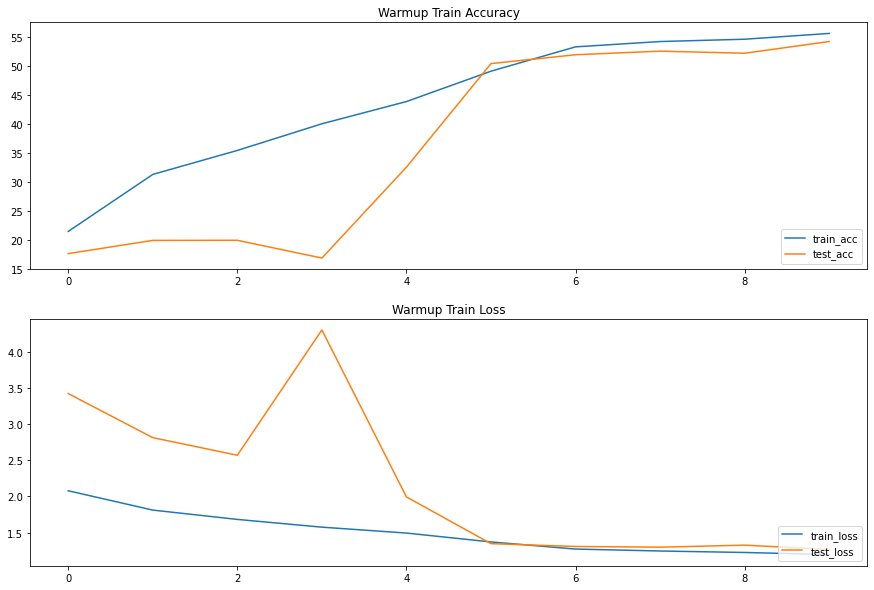

In [11]:
fig, axs = plt.subplots(2, figsize=(15,10))
axs[0].set_title('Warmup Train Accuracy')
axs[0].plot(training_accuracy,label='train_acc')
axs[0].plot(warmup_acc,label='test_acc')
axs[0].legend(loc='lower right')

axs[1].set_title('Warmup Train Loss')
axs[1].plot(training_loss,label='train_loss')
axs[1].plot(warmup_loss,label='test_loss')
axs[1].legend(loc='lower right')

### Generate `Pseudo-label` for all Unlabeled Data

In [9]:
# create psuedo-label for ulb data
def label(model):
    psuedolb = []
    model.eval()
    with torch.no_grad():
        for data, targets in ulb_loader:
            data = data.to(device)
            # targets = targets.to(device)
            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            predictions=predictions.cpu().numpy() # get np values of a tensor
            psuedolb.extend(predictions)
    return psuedolb

In [12]:
#create psusedo-lbl using trained model
chkpoint_dir = '../outputs/trained_model/ssl_clean/checkpoint_warmup_train.pth'
checkpoint = torch.load(chkpoint_dir)

model.load_state_dict(checkpoint["model_state_dict"])

psuedolb = label(model)

print("Outputs count: ",len(psuedolb))
df['Psuedo-lb'] = psuedolb

for idx, img_idx in enumerate(unlabelled_idx):
    train_dataset.targets[img_idx] = psuedolb[idx]

print("Created psuedo-label for ulb data")

Outputs count:  45000
Created psuedo-label for ulb data


In [13]:
print(df)

       img_idx  gt_label  Psuedo-lb
0        44353         8          8
1        49885         9          9
2         9778         1          9
3        33428         6          6
4        34298         6          6
...        ...       ...        ...
44995     5564         1          0
44996    11017         2          0
44997     4828         0          0
44998    13378         2          6
44999      336         0          0

[45000 rows x 3 columns]


In [14]:
num_epochs = 200
epoch_ratio = 0.08
ulb_train_acc, ulb_train_loss = [], []
test_acc, test_loss = [], []

# reset learning rate
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 40, gamma = 0.1)

def shuffle_ulb():
    ulb_batch_idx = []

    # select from ulb_idx
    ulb_batch_idx = random.choices(unlabelled_idx, k=round(unlabelled_size * epoch_ratio))
    
    # join the selected ulb with lbl
    for lbl_idx in label_idx:
        ulb_batch_idx.append(lbl_idx)

    epoch_dataset = Subset(train_dataset, ulb_batch_idx)

    epoch_loader = DataLoader(
        epoch_dataset, batch_size=16,
        num_workers=4, pin_memory=True,
    )

    return epoch_loader, ulb_batch_idx


def generate_psuedolbl(model, epoch):
    psuedolb = []
    # predict new psuedo-lbl for ulb dataset
    model.eval()
    with torch.no_grad():
        for data, targets in ulb_loader:
            data = data.to(device)
            # targets = targets.to(device)
            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            predictions=predictions.cpu().numpy() # get np values of a tensor
            psuedolb.extend(predictions)
    
    # update label of all ulb data
    # df['Psuedo-lb'] = psuedolb    
    for idx, img_idx in enumerate(unlabelled_idx):
        train_dataset.targets[img_idx] = psuedolb[idx]

    # print("Created new psuedo-lbl for ulb dataset")

def get_test_acc(model):
    model.eval()
    current_loss = 0
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            _, predictions = torch.max(scores, 1)
            correct += (predictions == targets).sum().item()
            loss = criterion(scores, targets)
            current_loss += loss.item() * data.size(0)
            
    epoch_loss = current_loss / test_size
    test_epoch_acc = correct / test_size * 100
    test_loss.append(epoch_loss)
    test_acc.append(test_epoch_acc)

    return test_epoch_acc

def ulb_train(current_epoch, num_epoch, model, loader):
    current_loss = 0.0
    current_corrects = 0
    model.train()

    loop = tqdm(enumerate(loader), total=len(loader)) # create a progress bar
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(scores, 1)
        current_loss += loss.item() * data.size(0)
        current_corrects += (preds == targets).sum().item()
        loop.set_description(f"Epoch {current_epoch+1}/{num_epoch} process: {int((batch_idx / len(loader)) * 100)}")
        loop.set_postfix(loss=loss.data.item())
    
    # save model
    # final_acc = current_corrects / unlabelled_size * 100
    # ulb_train_acc.append(final_acc)
    epoch_losses =  current_loss / label_size
    training_loss.append(epoch_losses)

    if (current_epoch+1) % 20 == 0:
        torch.save({ 
            'model_state_dict': model.state_dict(), 
            'optimizer_state_dict': optimizer.state_dict(), 
            }, os.path.join(save_path, 'ulb_train_checkpoint_epoch_' + str(current_epoch+1)+'.pth'))

### `Iterative training`

In [ ]:
# ground truth dataset to validate error
gt_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)

#convert into for loop eventually
print("New batch size(including lbl): ", label_size+round(unlabelled_size * epoch_ratio))

############### Start of main ulb training ######################
for current_epochs in range(num_epochs):
    train_correct = 0
    test_correct = 0
    psuedolb = []

    # handle model
    if current_epochs == 0:
        # load model trained with lbl data (warmup)
        model_dir = chkpoint_dir
        checkpoint = torch.load(model_dir)
        model.load_state_dict(checkpoint["model_state_dict"])
    
    # Shuffle ulb_idx for new train
    epoch_loader, ulb_batch_idx = shuffle_ulb()

    # Re-train the model
    ulb_train(current_epoch=current_epochs, num_epoch=num_epochs, model=model, loader=epoch_loader)
    
    # Generate new label (Save to train_dataset)
    generate_psuedolbl(model, current_epochs)
    
    # Get epoch_acc
    for idx in unlabelled_idx:
        # get train acc
        if train_dataset.targets[idx] == gt_dataset.targets[idx]:
            train_correct += 1

    final_acc = train_correct / unlabelled_size * 100
    ulb_train_acc.append(final_acc)
    
    # Get test_acc
    curr_test_acc = get_test_acc(model)

    print("Current Epoch:", current_epochs, " Train Acc:", final_acc, " Test Acc:", curr_test_acc)

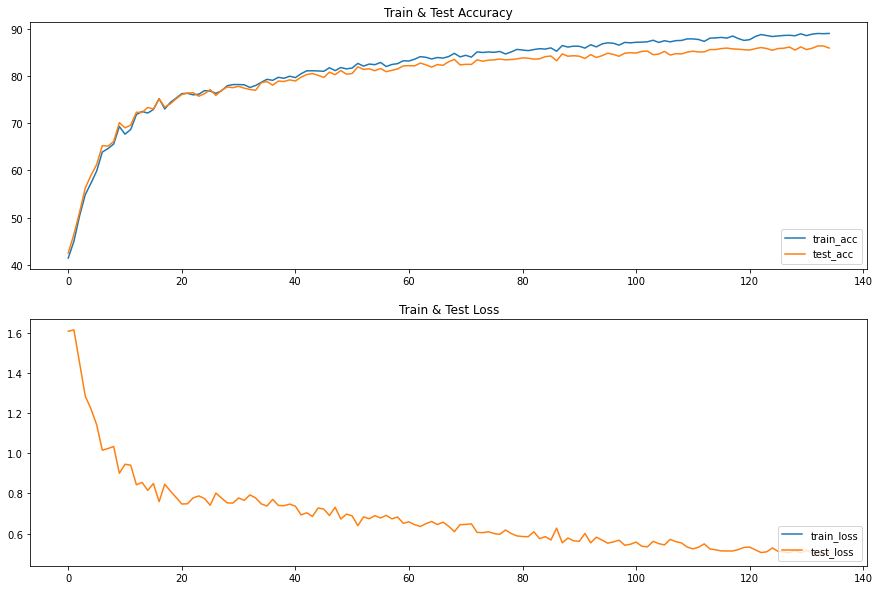

In [16]:
fig, axs = plt.subplots(2, figsize=(15,10))
axs[0].set_title('Train & Test Accuracy')
axs[0].plot(ulb_train_acc,label='train_acc')
axs[0].plot(test_acc,label='test_acc')
axs[0].legend(loc='lower right')

axs[1].set_title('Train & Test Loss')
axs[1].plot(ulb_train_loss,label='train_loss')
axs[1].plot(test_loss,label='test_loss')
axs[1].legend(loc='lower right')

In [19]:
top1_acc = max(test_acc)
best_model_state = test_acc.index(top1_acc)
top1_loss = test_loss[best_model_state]

#get train acc at that state
top1_train_acc = ulb_train_acc[best_model_state]

print("Top-1 Test Acc: ", top1_acc)
print("Loss: ", top1_loss)
print("Corresponding train acc: ", top1_train_acc)
print("Best model state: ", best_model_state)

Top-1 Test Acc:  86.32
Loss:  0.49958523085713386
Corresponding train acc:  88.96222222222222
Best model state:  132
